# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости.

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**Описание данных:**    

*Признаки:*
* *`DateCrawled`* — дата скачивания анкеты из базы
* *`VehicleType`* — тип автомобильного кузова
* *`RegistrationYear`* — год регистрации автомобиля
* *`Gearbox`* — тип коробки передач
* *`Power`* — мощность (л.с.)
* *`Model`* — модель автомобиля
* *`Kilometer`* — пробег (км)
* *`RegistrationMonth`* — месяц регистрации автомобиля
* *`FuelType`* — тип топлива
* *`Brand`* — марка автомобиля
* *`Repaired`* — была машина в ремонте или нет
* *`DateCreated`* — дата создания анкеты
* *`NumberOfPictures`* — количество фотографий автомобиля
* *`PostalCode`* — почтовый индекс владельца анкеты (пользователя)
* *`LastSeen`* — дата последней активности пользователя    

*Целевой признак:*
* *`Price`* — цена (евро)

## Подготовка данных

### Подготовка к работе

In [ ]:
# Обновим библиотеки
!pip install --upgrade scikit-learn==1.0

# Импортируем все необходимые нам библиотеки
import pandas as pd
import numpy as np
import time
import warnings
import seaborn as sns
import lightgbm as Light
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor, Pool

In [ ]:
# Активируется по окончанию проекта
# Проигнорируем предупреждения о возможных изменения работы функций в будущих версиях в Pandas
warnings.filterwarnings("ignore")

In [ ]:
# Зафиксируем константы
RANDOM_STATE = 42

In [ ]:
# Объявляем функцию для построения гистограммы и "ящика с усами" количественных данных
def hix_box_plot(column):
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,6))
    fig.suptitle(f'Обзор данных {column}', fontsize = 20, fontweight='bold')
    df[column].plot(ax=ax[0], kind='hist', bins=100)
    sns.boxplot(df[column], ax=ax[1])
    ax[0].set_title(f'Гистограмма', fontsize=16)
    ax[0].set_ylabel('Количество значений')
    ax[0].set_xlabel('Значения')
    ax[1].set_title(f'Диграмма размаха', fontsize=16)
    ax[1].set_xlabel(column)

In [ ]:
# Загружаем данные с возможностью загрузить их с сервера в случае недоступности локальных файлов
try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://***/datasets/autos.csv')

### Изучение данных

In [ ]:
# Объявляем функцию для изучения всей информации об датафрейме
def df_review(df):
    print('Краткое содержание датафрейма')
    display(df.head())
    print('='*100)
    print('Информация о датафрейме')
    df.info()
    print('='*100)
    print('Размер датафрейма:', df.shape)
    print('='*100)
    print('Охарактеризация числовых данных датафрейма')
    display(df.describe().T)
    print('='*100)
    print('Количество явных дубликатов в датафрейте:', df.duplicated().sum())
    print('Количество пропусков в датафрейте:', '\n', df.isna().sum())

In [ ]:
# Изучаем датафрейм
df_review(df)

Краткое содержание датафрейма


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


Информация о датафрейме
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
d

,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0


Количество явных дубликатов в датафрейте: 4
Количество пропусков в датафрейте: 
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


### Предобработка данных

#### Дубликаты

In [ ]:
# Удаляем дубликаты
df= df.drop_duplicates()

In [ ]:
# Проверим наличие дубликатов ещё раз
df.duplicated().sum()

0

#### Аномальные значения

Значения в столбце **RegistrationYear** явно имеет ошибочные данные, выявленные как аномалии.

In [ ]:
# Проверим дату выгрузки последней анкеты в датафрейме
df['DateCrawled'].max()

'2016-04-07 14:36:58'

In [ ]:
# Ограничим данные столбца RegistrationYear максимально возможными годами регистрации автомобилей
df = df.query('RegistrationYear < 2016')

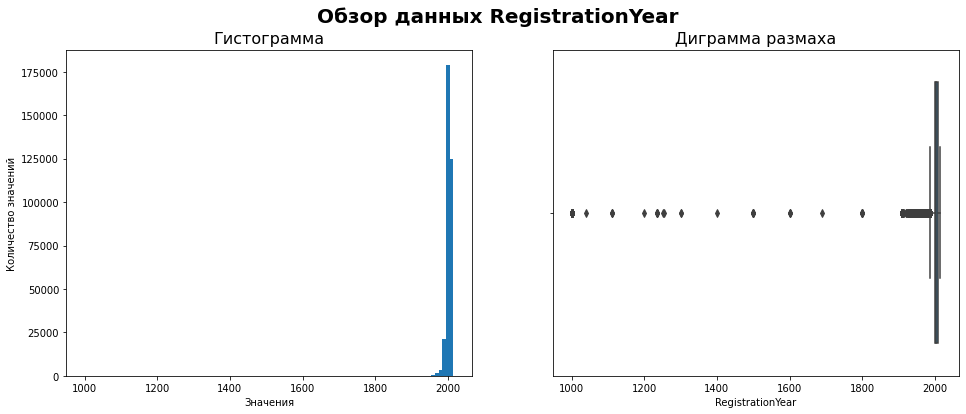

In [ ]:
# Проверим графики значений в столбце RegistrationYear
hix_box_plot('RegistrationYear')

In [ ]:
# Ограничим данные столбца RegistrationYear возможными годами регистрации автомобилей избавляясь от аномалий
df = df.query('RegistrationYear > 1960')

In [ ]:
# Проанализируем данные столбца RegistrationYear
df['RegistrationYear'].describe().T

count    329626.000000
mean       2002.182267
std           6.364607
min        1961.000000
25%        1999.000000
50%        2002.000000
75%        2007.000000
max        2015.000000
Name: RegistrationYear, dtype: float64

Значения в столбце **Power** явно имеет ошибочные данные, выявленные как аномалии.

In [ ]:
# Ограничим данные столбца Power реально возможной мощностью автомобиля
df = df.query('30 < Power < 1000')

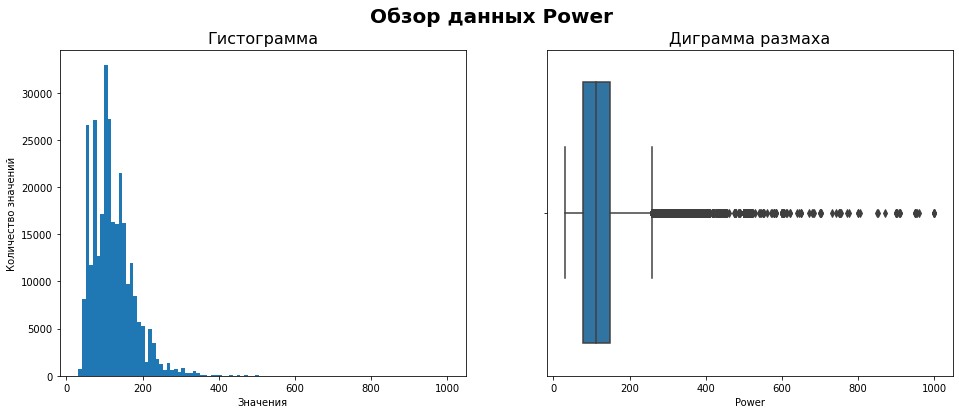

In [ ]:
# Проверим графики значений в столбце Power
hix_box_plot('Power')

In [ ]:
# Проанализируем данные столбца Power
df['Power'].describe().T

count    295199.000000
mean        121.402498
std          54.675079
min          31.000000
25%          77.000000
50%         113.000000
75%         150.000000
max         999.000000
Name: Power, dtype: float64

In [ ]:
# Дополнительно ограничим значения столбца Power, убрав аномалии
df = df.query('Power < 400')

Значения в столбце **Price** явно имеет ошибочные данные, выявленные как аномалии.

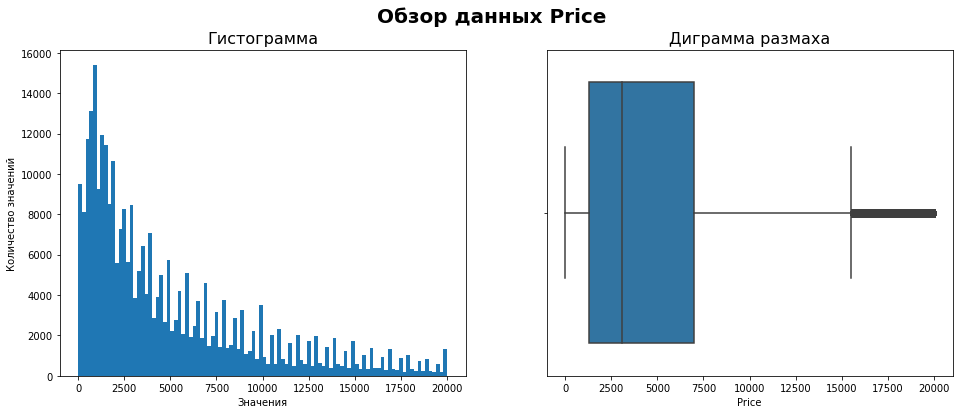

In [ ]:
# Проверим графики значений в столбце Price
hix_box_plot('Price')

In [ ]:
# Проверим уникальные значения столбца Price
df['Price'].value_counts()

0        5933
1500     4319
500      4249
1200     3621
2500     3618
         ... 
8069        1
13440       1
1925        1
1669        1
8188        1
Name: Price, Length: 3571, dtype: int64

Нулевые значения в столбце **Price** явно ошибочные. Т.к. данный столбец является целевым признаком, стоит удалить данные значения. Так же согласно поискам в интернете реальные цены в евро на поддержанные автомобили начинаются от 500 евро. Ограничим значения этим.

In [ ]:
# Удалим нулевые значения
df = df.query('Price >= 500')

#### Лишние столбцы

Данный датафрейм имеет столбцы, не содержащие информацию об автомобиле. Удалим следующие столбцы:
* *`DateCrawled`* — дата скачивания анкеты из базы
* *`RegistrationMonth`* — месяц регистрации автомобиля
* *`DateCreated`* — дата создания анкеты
* *`NumberOfPictures`* — количество фотографий автомобиля
* *`PostalCode`* — почтовый индекс владельца анкеты (пользователя)
* *`LastSeen`* — дата последней активности пользователя

In [ ]:
# Удаляем лишние столбцы
df = df.drop(columns=['DateCrawled', 'RegistrationMonth', 'DateCreated', 'NumberOfPictures', 'LastSeen', 'PostalCode'])

In [ ]:
# Проверим наличие дубликатов ещё раз
df.duplicated().sum()

37305

In [ ]:
# Удаляем дубликаты
df= df.drop_duplicates()

In [ ]:
# Проверим наличие дубликатов ещё раз
df.duplicated().sum()

0

#### Пропуски

Причина пропусков в столбце **VehicleType** не известна, потому заменим значение на *"неизвестно"*(**"unknown"**).

In [ ]:
df['VehicleType'] = df['VehicleType'].fillna(value="unknown")

Причина пропусков в столбце **Model** так же не известна, так же заменим значение на *"неизвестно"*(**"unknown"**).

In [ ]:
df['Model'] = df['Model'].fillna(value="unknown")

Заменим пропуски в столбце **Gearbox** на моду, сгруппировав данные по марке и модели автомобиля.

In [ ]:
df['Gearbox']= df.groupby(['Brand', 'Model'])['Gearbox'].transform(lambda x: x.fillna((x.mode()[0])))

Заменим пропуски в столбце **FuelType** на моду, сгруппировав данные по марке и модели автомобиля.

In [ ]:
df['FuelType']= df.groupby(['Brand', 'Model'])['FuelType'].transform(lambda x: x.fillna((x.mode()[0])))

В столбце **Repaired** содержится информация о капитальных ремонтах автомобиля и пропуски скорее всего связаны с отсутствием капитального ремонта у автомобиля. Заменим пропуски на **no**.

In [ ]:
df['Repaired'] = df['Repaired'].fillna(value="no")

In [ ]:
# Проверяем пропуски ещё раз
df.isna().sum()

Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64

### Вывод по подготовке данных

Во время подготовки данных была проделана следующая работа:
* Подготовка к работе:
  * Все библиотеки импортированы
  * Константы зафиксированы
  * Данные загружены
* Изучение данных:
  * Краткое содержание датафрейма проверено
  * Информация о датафрейме проверена
  * Размерность датафрейма проверена
  * Числовые данные охарактеризованы
  * Дубликаты проверены
  * Пропуски проверены
* Предобработка данных:
  * Дубликаты удалены
  * Аномальные значения в следующих столбцах обработаны:
    * **RegistrationYear**
    * **Power**
    * **Price**
  * Безынформативные столбцы датафрейма удалены:
    * **DateCrawled**
    * **RegistrationMonth**
    * **DateCreated**
    * **NumberOfPictures**
    * **PostalCode**
    * **LastSeen**
  * Пропуски в следующих столбцах обработаны:
    * **VehicleType**
    * **Model**
    * **Gearbox**
    * **FuelType**
    * **Repaired**


## Обучение моделей

### Раздел датафрейма на выборки

In [ ]:
# Создадим список категориальных признаков
cat_features=["VehicleType","Gearbox","Model","FuelType", "Brand","Repaired"]

In [ ]:
# Создадим список численных признаков
num_features=["RegistrationYear","Power","Kilometer"]

In [ ]:
# Разделим датафрейм на признаки и целевой признак
X = df.drop('Price',axis=1)
y = df['Price']

# Разделим датафрейм на тренировочную и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.75, random_state=RANDOM_STATE)

# Дополнительно из тренировочной выборки отделим валидационную выборку
# X_train_2, X_valid, y_train_2, y_valid = train_test_split(X_train, y_train, train_size=0.75, random_state=RANDOM_STATE)

# Кодируем данные
ohe = OneHotEncoder(drop='first', handle_unknown = 'ignore', sparse=False)
X_train_ohe = ohe.fit_transform(X_train[cat_features])
X_test_ohe = ohe.transform(X_test[cat_features])
encoder_col_names = ohe.get_feature_names()
X_train_ohe = pd.DataFrame(X_train_ohe, columns=encoder_col_names)
X_test_ohe = pd.DataFrame(X_test_ohe, columns=encoder_col_names)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train[num_features])
X_test_scaled = scaler.transform(X_test[num_features])
X_train_scaled = pd.DataFrame(X_train_scaled, columns=num_features)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=num_features)

X_train = pd.concat([X_train_ohe, X_train_scaled], axis=1)
X_test = pd.concat([X_test_ohe, X_test_scaled], axis=1)

In [ ]:
# Посмотрим на размеры выборок
print('Размер датафрейма X_train:')
print(X_train.shape)
# print('Размер датафрейма X_train_2:')
# print(X_train_2.shape)
print('Размер датафрейма X_test:')
print(X_test.shape)
# print('Размер датафрейма X_valid:')
# print(X_valid.shape)
print('Размер датафрейма y_train:')
print(y_train.shape[0])
# print('Размер датафрейма y_train_2:')
# print(y_train_2.shape[0])
print('Размер датафрейма y_test:')
print(y_test.shape[0])
# print('Размер датафрейма y_valid:')
# print(y_valid.shape[0])

Размер датафрейма X_train:
(176871, 306)
Размер датафрейма X_test:
(58957, 306)
Размер датафрейма y_train:
176871
Размер датафрейма y_test:
58957


### LinearRegression

In [ ]:
start = time.time()

# Создаём модель
model_LR = LinearRegression()

# Создаём словарь гиперпараметров для подбора
param_grid = {
    'fit_intercept': [True, False],
    'normalize': [True, False],
    'n_jobs': [1, -1]
}
# Создаем и обучаем подборку гиперпараметров
grid = GridSearchCV(estimator=model_LR, param_grid=param_grid, cv=3, scoring='neg_mean_squared_error')
grid.fit(X_train, y_train)

# Сохраняем лучшие гиперпараметры для модели
best_params = grid.best_params_

# Создаем новую модель с лучшими гиперпараметрами
best_model_LR = LinearRegression(**best_params)

# Обучаем модель
best_model_LR.fit(X_train, y_train)

end = time.time()

# Сохраняем время обучения модели в переменную
model_LR_train_time = (end - start)

rmse_LR = abs(grid.best_score_)**0.5
print("Лучшие гиперпараметры модели: ", best_params)
print("RMSE модели: %.2f" % rmse_LR)

Лучшие гиперпараметры модели:  {'fit_intercept': True, 'n_jobs': 1, 'normalize': False}
RMSE модели: 2563.93


In [ ]:
start = time.time()

# Проверяем модель на тренировочной выборке
train_predictions_LR = best_model_LR.predict(X_train)

end = time.time()

# Сохраняем время предсказания модели в переменную
model_LR_pred_time = (end - start)

### CatBoost

In [ ]:
start = time.time()

# Создаём модель

model_Cat = CatBoostRegressor(
    iterations=1000,
    random_state=RANDOM_STATE,
    loss_function='RMSE',
    early_stopping_rounds=50
)

# Обучаем модель

model_Cat.fit(
    X_train, y_train,
    eval_set=(X_test, y_test),
    verbose=50
)

end = time.time()

# Сохраняем время обучения модели в переменную
model_CatBoost_train_time = (end - start)

Learning rate set to 0.114757
0:	learn: 4291.8412663	test: 4318.9906971	best: 4318.9906971 (0)	total: 80.8ms	remaining: 1m 20s
50:	learn: 1853.1971720	test: 1870.7391166	best: 1870.7391166 (50)	total: 1.24s	remaining: 23.1s
100:	learn: 1743.2963785	test: 1763.5169277	best: 1763.5169277 (100)	total: 2.38s	remaining: 21.2s
150:	learn: 1691.8094143	test: 1716.6918668	best: 1716.6918668 (150)	total: 3.53s	remaining: 19.9s
200:	learn: 1658.9549416	test: 1688.5982529	best: 1688.5982529 (200)	total: 4.68s	remaining: 18.6s
250:	learn: 1634.1018758	test: 1668.1915771	best: 1668.1915771 (250)	total: 5.83s	remaining: 17.4s
300:	learn: 1613.3930657	test: 1652.1515727	best: 1652.1515727 (300)	total: 6.97s	remaining: 16.2s
350:	learn: 1598.9875358	test: 1641.1679653	best: 1641.1679653 (350)	total: 8.09s	remaining: 15s
400:	learn: 1586.2146286	test: 1631.8754104	best: 1631.8754104 (400)	total: 9.25s	remaining: 13.8s
450:	learn: 1575.5182589	test: 1623.3687529	best: 1623.3687529 (450)	total: 10.3s	rem

In [ ]:
start = time.time()

# Проверяем модель на тренировочной выборке
train_predictions_CatBoost = model_Cat.predict(X_train)

end = time.time()

# Сохраняем время предсказания модели в переменную
model_CatBoost_pred_time = (end - start)

# Считаем метрику RMSE на тренировочной выборке
rmse_CatBoost = mean_squared_error(y_train, train_predictions_CatBoost, squared=False)

print("RMSE модели: %.2f" % rmse_CatBoost)

RMSE модели: 1500.91


### LightGBM

In [ ]:
start = time.time()

# Создаём словарь параметров
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': 'rmse',
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    'n_jobs': -1
}

# Задаём выборки для модели
Light_train = Light.Dataset(X_train, y_train)
Light_test = Light.Dataset(X_test, y_test)

model_Light = Light.train(params,
                      Light_train,
                      num_boost_round=1000,
                      valid_sets=[Light_train, Light_test],
                      early_stopping_rounds=50,
                      verbose_eval=50)

end = time.time()

# Сохраняем время обучения модели в переменную
model_Light_train_time = (end - start)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.092250 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
Training until validation scores don't improve for 50 rounds
[50]	training's rmse: 1924.92	valid_1's rmse: 1945.21
[100]	training's rmse: 1711.11	valid_1's rmse: 1735.04
[150]	training's rmse: 1656.98	valid_1's rmse: 1685.3
[200]	training's rmse: 1626.97	valid_1's rmse: 1659.55
[250]	training's rmse: 1604.76	valid_1's rmse: 1642.57
[300]	training's rmse: 1587.14	valid_1's rmse: 1629.85
[350]	training's rmse: 1574.31	valid_1's rmse: 1620.93
[400]	training's rmse: 1562.43	valid_1's rmse: 1614.05
[450]	training's rmse: 1551.67	valid_1's rmse: 1607.83
[500]	training's rmse: 1541.2	valid_1's rmse: 1601.19
[550]	training's rmse: 1532.27	valid_1's rmse: 1597.04
[600]	training's rmse: 1524.83	valid_1's rmse: 1593.16
[650]	training's rmse: 1516.81	valid_1's rmse: 1588.5

In [ ]:
start = time.time()

# Проверяем модель на тренировочной выборке
train_predictions_Light = model_Light.predict(X_train)

end = time.time()

# Сохраняем время предсказания модели в переменную
model_Light_pred_time = (end - start)

# Считаем метрику RMSE на тренировочной выборке
rmse_Light = mean_squared_error(y_train, train_predictions_Light, squared=False)

print("RMSE модели: %.2f" % rmse_Light)

RMSE модели: 1478.82


## Анализ моделей

### Проверка моделей на валидационной выборке

#### LinearRegression

#### CatBoost

#### LightGBM

### Охарактеризация моделей

In [ ]:
# Создадим датафрейм с характеристиками моделей
final_data = pd.DataFrame({'Модель': ['LinearRegression','CatBoost', 'LightGBM'],
                        'Время обучения(сек)': [model_LR_train_time, model_CatBoost_train_time, model_Light_train_time],
                        'Время предсказания(сек)': [model_LR_pred_time, model_CatBoost_pred_time, model_Light_pred_time],
                        'Значение метрики RMSE': [rmse_LR, rmse_CatBoost, rmse_Light]})

### Выбор лучшей модели

In [ ]:
# Посмотрим на таблицу с характеристиками моделей
final_data

,Модель,Время обучения(сек),Время предсказания(сек),Значение метрики RMSE
0,LinearRegression,270.953648,0.193227,2563.926182
1,CatBoost,25.468443,0.306654,1500.912478
2,LightGBM,65.320346,24.743309,1478.817692


По итогу самой быстрой моделью оказалась **CatBoost**. Лучшую метрику RMSE показала модель **LightGBM**, но данная модель показала себя с худшей стороны по времени обучения и предсказания.

Окончательным решением было принято выбрать модель градиентного бустинга **CatBoost**, как самый оптимальный вариант по времени обучения и предсказаний и по качеству предсказаний.

### Проверка лучшей модели на тестовой выборке

In [ ]:
# Проверяем модель на тестовой выборке
predictions_CatBoost = model_Cat.predict(X_test)

# Считаем метрику RMSE на тренировочной выборке
test_rmse_CatBoost = mean_squared_error(y_test, predictions_CatBoost, squared=False)

print("RMSE модели: %.2f" % test_rmse_CatBoost)

RMSE модели: 1579.15


**Модель CatBoost полностью подходит под требования заказчика!**👍

## Общий вывод

Во время работы над проектом было сделано:
* Подготовка данных:
  * Подготовка к работе:
    * Все библиотеки импортированы
    * Константы зафиксированы
    * Данные загружены
  * Изучение данных:
    * Краткое содержание датафрейма проверено
    * Информация о датафрейме проверена
    * Размерность датафрейма проверена
    * Числовые данные охарактеризованы
    * Дубликаты проверены
    * Пропуски проверены
  * Предобработка данных:
    * Дубликаты удалены
    * Аномальные значения в следующих столбцах обработаны:
      * **RegistrationYear**
      * **Power**
      * **Price**
    * Безынформативные столбцы датафрейма удалены:
      * **DateCrawled**
      * **RegistrationMonth**
      * **DateCreated**
      * **NumberOfPictures**
      * **PostalCode**
      * **LastSeen**
    * Пропуски в следующих столбцах обработаны:
      * **VehicleType**
      * **Model**
      * **Gearbox**
      * **FuelType**
      * **Repaired**
* Обучение моделей:
 * Датафрейм поделён на выборки
 * Обучены 3 модели:
   * **LinearRegression**
   * **CatBoost**
   * **LightGBM**
* Анализ моделей:
  * Все модели проверены
  * Была выбрана лучшая модель:
    * **CatBoost** - RMSE - 1579